In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from xgboost.sklearn import XGBClassifier

C:\Users\seanm\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\seanm\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\seanm\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def ensemble_params(X_train, y_train, CV = 5, boosted = True):
    ## Logistic regression C
    log = LogisticRegression( max_iter = 1000)
    params = {'C': [1.0,100.0]}
    grid_log = GridSearchCV(log, params, cv = CV)
    grid_log.fit(X_train, y_train)
    log_C = grid_log.best_params_['C']
    print("Log complete")
    ## K-neirest neighbor
    KNN = KNeighborsClassifier()
    params = {'n_neighbors': [3,4,5,6,7,8,9,10]}
    grid_KNN = GridSearchCV(KNN, params, cv = CV)
    grid_KNN.fit(X_train, y_train)
    k_neighbors = grid_KNN.best_params_['n_neighbors']
    print("knn complete")
    ## Decision tree max depth
    tree = DecisionTreeClassifier()
    params = {'max_depth': [3,4,5,6,7,8,9,10]}
    grid_tree = GridSearchCV(tree, params, cv = CV)
    grid_tree.fit(X_train, y_train)
    tree_max_depth = grid_tree.best_params_['max_depth']
    print("tree complete")
    ## Random forest max depth
    rnd = RandomForestClassifier()
    params = {'max_depth': [3,4,5,6,7,8,9,10]}
    grid_rnd = GridSearchCV(rnd, params, cv = CV)
    grid_rnd.fit(X_train, y_train)
    rnd_max_depth = grid_rnd.best_params_['max_depth']
    print("rnd complete")
    ## Support vector machine
    svm = SVC(probability= True)
    params = {'C':[1,2,3,4,5]} 
    grid_svm = GridSearchCV(svm, params, cv = CV)
    grid_svm.fit(X_train, y_train)
    svm_C = grid_svm.best_params_['C']
    print("svm complete")
    if boosted:
        ## Gradient boosting
        gbc = GradientBoostingClassifier( learning_rate=0.1)
        params = {'n_estimators': [50,75,100,125,150],
        'max_depth':[3,4,5,6,7,8,9,10,11,12]} 
        grid_gbc = GridSearchCV(gbc, params, cv = CV)
        grid_gbc.fit(X_train, y_train)
        gbc_n_estimators = grid_gbc.best_params_['n_estimators']
        gbc_max_depth = grid_gbc.best_params_['max_depth']
        print("GBC complete")
        ## ADA boosting
        ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), algorithm= 'SAMME.R', learning_rate=0.1)
        params = {'n_estimators': [50,75,100,125,150]} 
        grid_ada = GridSearchCV(ada, params, cv = CV)
        grid_ada.fit(X_train, y_train)
        ada_n_estimators = grid_ada.best_params_['n_estimators']
        print("ADA complete")
    else:
        gbc_n_estimators = 0 
        gbc_max_depth = 0
        ada_n_estimators = 0

    return {'log_C':log_C, 'k_neighbors':k_neighbors, 'tree_max_depth':tree_max_depth, 'rnd_max_depth':rnd_max_depth, 'svm_C':svm_C, 'gbc_n_estimators':gbc_n_estimators, 'gbc_max_depth':gbc_max_depth, 'ada_n_estimators':ada_n_estimators}

In [3]:
def fit_ensemble(X_train, y_train, X_test, log_C, k_neighbors, tree_max_depth, rnd_max_depth, svm_C, gbc_n_estimators, gbc_max_depth, ada_n_estimators, boosted = True):
    if boosted:
        log_v = LogisticRegression( max_iter = 1000, C = log_C)
        knn_v = KNeighborsClassifier(n_neighbors = k_neighbors, n_jobs= -1)
        tree_v = DecisionTreeClassifier(max_depth = tree_max_depth)
        rnd_v = RandomForestClassifier(max_depth= rnd_max_depth)
        svm_v = SVC(probability= True, C = svm_C)
        gbc_v = GradientBoostingClassifier( learning_rate=0.1, n_estimators = gbc_n_estimators,  
                                            max_depth = gbc_max_depth)
        ada_v = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), 
                                                algorithm= 'SAMME.R', 
                                                    learning_rate=0.1,
                                                    n_estimators= ada_n_estimators)

        voter_c = VotingClassifier(estimators= [('lr',log_v), 
            ('KNN', knn_v),
            ('Tree',tree_v),
            ('rf',rnd_v),
            ('SVM',svm_v),
            ('boosted',gbc_v),
            ('ADA',ada_v)
            ], voting = 'soft')
    else:
        log_v = LogisticRegression( max_iter = 1000, C = log_C)
        knn_v = KNeighborsClassifier(n_neighbors = k_neighbors)
        tree_v = DecisionTreeClassifier(max_depth = tree_max_depth)
        rnd_v = RandomForestClassifier(max_depth= rnd_max_depth)
        svm_v = SVC(probability= True, C = svm_C)

        voter_c = VotingClassifier(estimators= [('lr',log_v), 
            ('KNN', knn_v),
            ('Tree',tree_v),
            ('rf',rnd_v),
            ('SVM',svm_v)
            ], voting = 'soft') 
            
    voter_c.fit(X_train, y_train)   
    y_preds = voter_c.predict(X_test)
    return y_preds

In [29]:
def METRICS(y_test, y_preds):
    cm = confusion_matrix(y_test,y_preds)
    Accuracy = [cm[0][0]/(cm[0][0] + cm[0][1]),cm[1][1]/(cm[1][0] + cm[1][1])]
    fr, sr, threshold = roc_curve(y_test,y_preds)
    AUC = auc(fr,sr)
    print(f"Non-voter accuracy = {round(Accuracy[0], 2)}. Voter accuracy = {round(Accuracy[1], 2)}. Total = {round(sum(Accuracy)/2, 2)}. AUC = {round(AUC, 2)}")

In [5]:
def compile_and_test(X_train, y_train, X_test, y_test, cv = 5):
    log_C, k_neighbors, tree_max_depth, rnd_max_depth, svm_C, gbc_n_estimators, gbc_max_depth, ada_n_estimators = ensemble_params(X_train, y_train, CV = cv)
    predictions = fit_ensemble(X_train, y_train, X_test, log_C, k_neighbors, tree_max_depth, rnd_max_depth, svm_C, gbc_n_estimators, gbc_max_depth, ada_n_estimators)
    METRICS(y_test, predictions)

In [26]:
data = pd.read_csv(r'C:\Users\seanm\OneDrive\Documents\C - Research\NonVoters\Voter_Predictions\Data and Preperation\CCES data\clean_cces_data.csv')
data = data.drop('vv_party_prm', axis = 1)
data = data.dropna()
data['approvalXparty'] = list(map(lambda x,y: int(x)*int(y), data['pid3_leaner'], data['approval_pres']))
y = data['voted']
X = data.iloc[:, 2:]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= .25, random_state= 123)

In [9]:
log = KNeighborsClassifier(n_jobs=-1)
log.fit(X_train, y_train)
y_preds = log.predict(X_test)

In [9]:
gbc = GradientBoostingClassifier(max_depth=6,  learning_rate=0.1,  n_estimators= 150)
gbc.fit(X_train,y_train)
y_preds = gbc.predict(X_test)

In [10]:
METRICS(y_test, y_preds)

Non-voter accuracy = 0.57. Voter accuracy = 0.83. Total = 0.7. AUC = 0.7


In [ ]:
## Logistic regression C
log = LogisticRegression( max_iter = 1000)
params = {'C': [1.0,100.0]}
grid_log = GridSearchCV(log, params, cv = CV)
grid_log.fit(X_train, y_train)
log_C = grid_log.best_params_['C']
print("Log complete")

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [25]:
## Decision tree max depth
tree = DecisionTreeClassifier()
params = {'max_depth': [3,4,5,6,7,8,9,10]}
grid_tree = GridSearchCV(tree, params, cv = 2)
grid_tree.fit(X_train, y_train)
tree_max_depth = grid_tree.best_params_['max_depth']
print("tree complete")

tree complete


In [27]:
## Random forest max depth
rnd = RandomForestClassifier()
params = {'max_depth': [3,4,5,6,7,8,9,10]}
grid_rnd = GridSearchCV(rnd, params, cv = 2)
grid_rnd.fit(X_train, y_train)
rnd_max_depth = grid_rnd.best_params_['max_depth']
print("rnd complete")

rnd complete


In [29]:
## Support vector machine
svm = SVC(probability= True)
params = {'C':[1,2,3,4,5]} 
grid_svm = GridSearchCV(svm, params, cv = 2)
grid_svm.fit(X_train, y_train)
svm_C = grid_svm.best_params_['C']
print("svm complete")

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [8]:
best_params = {'log_C':1, 'k_neighbors':5, 'tree_max_depth':12, 'rnd_max_depth':12, 'svm_C':1, 'gbc_n_estimators':14, 'gbc_max_depth':14, 'ada_n_estimators':13}

In [16]:
log_v = LogisticRegression( max_iter = 1000, C = 1)
#knn_v = KNeighborsClassifier(n_neighbors = k_neighbors, n_jobs= -1)
tree_v = DecisionTreeClassifier(max_depth = 13)
rnd_v = RandomForestClassifier(max_depth= 13)
#svm_v = SVC(probability= True, C = 1)
gbc_v = GradientBoostingClassifier( learning_rate=0.1, n_estimators = 140,  
                                    max_depth = 14)
ada_v = AdaBoostClassifier(DecisionTreeClassifier(max_depth=14), 
                                        algorithm= 'SAMME.R', 
                                            learning_rate=0.1,
                                            n_estimators= 140)

voter_c = VotingClassifier(estimators= [('lr',log_v), 
    #('KNN', knn_v),
    ('Tree',tree_v),
    ('rf',rnd_v),
    #('SVM',svm_v),
    ('boosted',gbc_v),
    ('ADA',ada_v)
    ], voting = 'soft')
voter_c.fit(X_train, y_train)   
y_preds = voter_c.predict(X_test)
    

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [13]:
def modelfit(alg, X_trin, y_train, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train[predictors].values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train[predictors], y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [36]:
#bst = xgb.XGBClassifier(eta = .01, max_depth = 5, colsample_bytree = 1, objective = "binary:logistic", eval_metric = "auc", min_child_weight = 1, gamma = 0,subsample = .8, colsample_bytree = 0.8)

predictors = [x for x in X_train.columns]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, X_train, y_train, predictors)
#bst.fit(X_train, y_train)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [41]:
param_test1 = {
 'max_depth':range(5,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

C:\Users\seanm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [43]:
gsearch1.best_params_, gsearch1.best_score_

### max_depth = 6, min_child_weight = 4

({'max_depth': 6, 'min_child_weight': 4}, 0.7865956847083159)

In [44]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch4.best_score_
## gamma = 0

C:\Users\seanm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[13:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.0}, 0.7865956847083159)

In [45]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_
## colsample_bytree = 0.8, subsample = 0.9

C:\Users\seanm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.7866521558964438)

In [46]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

C:\Users\seanm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0.1}, 0.7867745225812092)

In [48]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

C:\Users\seanm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0}, 0.7866521558964438)

In [49]:
param_test5 = {
 'n_estimators':[150, 500, 1000, 2000],
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.01, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, reg_alpha = .1), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

C:\Users\seanm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:26:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'n_estimators': 2000}, 0.7876706049349357)

In [28]:
xgb = XGBClassifier( learning_rate =0.01, n_estimators= 2000, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, reg_alpha = .1)
xgb.fit(X_train,y_train)
y_preds = xgb.predict(X_test)

[09:53:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
METRICS(y_test, y_preds)

Non-voter accuracy = 0.49. Voter accuracy = 0.87. Total = 0.68. AUC = 0.68


In [14]:
def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    #alg.fit(X_train,y_train)

    y_preds = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(y_test, y_preds))
    print ("AUC Score (Test): %f" % roc_auc_score(y_test, dtrain_predprob))

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))   
     #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7181
AUC Score (Test): 0.751611


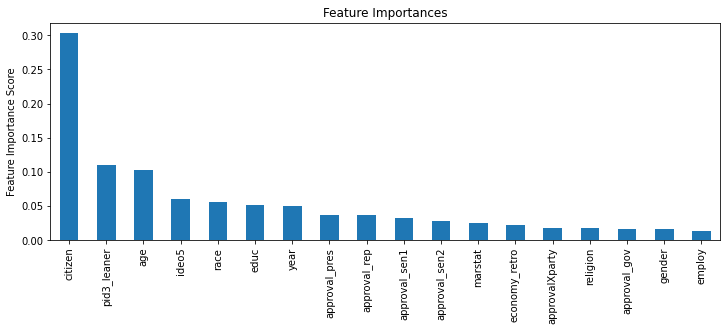

In [31]:
import warnings
warnings.filterwarnings("ignore")
modelfit(xgb, X_train, y_train, X_test, y_test, performCV =False)

In [54]:
predictors = [x for x in X_train.columns]
modelfit(xgb, X_train, y_train, predictors)

AttributeError: 'XGBClassifier' object has no attribute 'DMatrix'

In [ ]:
## for each unique year:
### include only that year
### dropna() or na_columns
### train_test_split data
### fit params
### provide metrics for total
### for each column:
#### print column
#### leave out column
#### fit based off params 
#### print metrics